In [2]:
import os
import sys

PATH_TO_MODELS = f'../Spatial-LDA/models/'
PATH_TO_PATIENT_DFS_PKL = f'../Spatial-LDA/patient_dfs1.pkl'
PATH_TO_TUMOR_MARKER_FEATURES_PKL = f'../Spatial-LDA/tumor_marker_features1.pkl'
PATH_TO_COHORT_METADATA = f'../Spatial-LDA/mibitof_cohort_metadata1.xlsx'

paths = [
  PATH_TO_MODELS,
  PATH_TO_PATIENT_DFS_PKL,
  PATH_TO_TUMOR_MARKER_FEATURES_PKL, 
  PATH_TO_COHORT_METADATA
]

In [8]:
#@title Import and set processes and set training params
%load_ext autoreload
%autoreload 2

import functools
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pickle
import scipy
from sklearn.model_selection import train_test_split
import time
import tqdm

# Spatial LDA imports
from spatial_lda.featurization import featurize_tumors
from spatial_lda.featurization import neighborhood_to_marker
from spatial_lda.featurization import make_merged_difference_matrices
import spatial_lda.model
from spatial_lda.visualization import plot_samples_in_a_row
from spatial_lda.visualization import plot_one_tumor_all_topics
from spatial_lda.visualization import plot_one_tumor_topic
from spatial_lda.visualization import plot_topics_heatmap

N_PARALLEL_PROCESSES =  8#@param
TRAIN_SIZE_FRACTION = 0.9 #@param
N_TOPICS = 5 #@param
DIFFERENCE_PENALTY = 250 #@param
RETRAIN_MODEL = False#@param

logger = logging.getLogger()
logger.setLevel(logging.INFO)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# load the data
N_IMMUNE_CLUSTERS = 9

with open(PATH_TO_PATIENT_DFS_PKL, 'rb') as f:
   patient_dfs = pickle.load(f)

# for patient_id in patient_dfs.keys():
#  df = patient_dfs[patient_id]
#  df['combined_cluster_id'] = (df['immune_cluster'].fillna(0) + 
#                               (df.cluster_id + N_IMMUNE_CLUSTERS).fillna(0))
#  df.loc[df['combined_cluster_id'] == 0, 'combined_cluster_id'] = None
#  df.loc[:, 'is_tumor'] = ~df['isimmune']
#  patient_dfs[patient_id] = df
  
  
# compartmentalized_tumors = [3, 4, 5, 6, 9, 10, 16, 28, 32, 35, 36, 37, 40, 41]
# noncompartmentalized_tumors = [x for x in patient_dfs.keys() 
#                               if x not in compartmentalized_tumors]
# immune_cluster_names={8:'Treg',6:'MF/Glia',1:'B',4:'CD11c-high',7:'NK',0:'CD4T',
#                      2:'DC',3:'CD8T',10:'MF',11:'Neutrophil',9:'Other', 5:'MF'}
# other_cluster_names={0:'Epithelial',2:'Tumor/Keratin',3:'Tumor/EGFR',
#                     4:'Endothelial/Vim',1:'Mesenchymal/SMA'}

markers = patient_dfs[1].columns[0:65]
num_patients = 2

In [5]:
# featurize and save
if os.path.exists(PATH_TO_TUMOR_MARKER_FEATURES_PKL):
  with open(PATH_TO_TUMOR_MARKER_FEATURES_PKL, 'rb') as f:
    tumor_marker_features = pickle.load(f)
else:
  neighborhood_feature_fn = functools.partial(neighborhood_to_marker, 
                                              markers=markers)
  tumor_marker_features = featurize_tumors(patient_dfs, 
                                           neighborhood_feature_fn, 
                                           radius=100,
                                           n_processes=N_PARALLEL_PROCESSES)
  with open(PATH_TO_TUMOR_MARKER_FEATURES_PKL, 'wb') as f:
    pickle.dump(tumor_marker_features, f)

In [6]:
%%time
# split training set and compute difference matrices
# Subsample tumor cells
all_tumor_idxs = tumor_marker_features.index.map(lambda x: x[0])
_sets = train_test_split(tumor_marker_features, 
                         test_size=1. - TRAIN_SIZE_FRACTION,
                         stratify=all_tumor_idxs)
train_tumor_marker_features, test_tumor_marker_features = _sets
train_difference_matrices = make_merged_difference_matrices(
    train_tumor_marker_features, patient_dfs, 'x', 'y')
tumor_idxs = train_tumor_marker_features.index.map(lambda x: x[0])

CPU times: user 185 ms, sys: 895 µs, total: 186 ms
Wall time: 185 ms


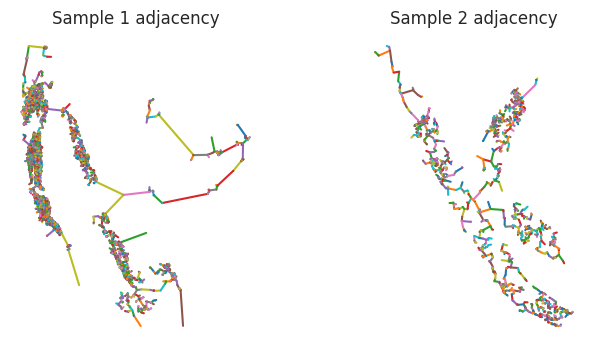

In [7]:
# visualize graphs used to tie neighboring environments
from spatial_lda.visualization import plot_adjacency_graph

def make_plot_fn(difference_matrices):  
    def plot_fn(ax, tumor_idx, features_df, patient_dfs):
        plot_adjacency_graph(ax, tumor_idx, features_df, patient_dfs, difference_matrices)
    return plot_fn
_plot_fn = make_plot_fn(train_difference_matrices)

plot_samples_in_a_row(train_tumor_marker_features, _plot_fn, patient_dfs, tumor_set=[1, 2])

In [10]:
# inspect the microenvironment data
tumor_marker_features

,Beta catenin,Ca,CD11b,CD11c,CD138,CD16,CD20,CD209,CD3,CD31,...,P,p53,Pan-Keratin,PD-L1,PD1,phospho-S6,Si,SMA,Ta,Vimentin
"(1, 0)",0,11,0,0,0,0,2,0,0,0,...,10,0,0,0,0,7,7,1,9,2
"(1, 2)",0,12,0,0,0,0,1,0,0,0,...,10,0,0,0,0,5,4,2,7,3
"(1, 4)",0,14,0,0,0,0,3,0,0,0,...,13,0,0,0,0,7,3,2,7,3
"(1, 5)",0,12,0,0,0,0,3,0,0,0,...,11,0,0,0,0,5,2,2,6,3
"(1, 6)",0,11,0,0,0,0,4,0,0,0,...,10,0,0,0,0,5,0,2,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(41, 4559)",0,10,0,0,0,0,0,0,0,0,...,10,0,0,0,0,0,8,0,4,5
"(41, 4560)",0,5,0,0,0,0,0,0,0,0,...,4,0,0,0,0,0,5,0,4,2
"(41, 4561)",0,10,0,0,0,0,0,0,0,0,...,9,0,0,0,0,0,9,0,6,7
"(41, 4563)",0,4,0,0,0,0,0,0,0,0,...,4,0,0,0,0,0,4,0,4,3


In [9]:
# fit spatial-LDA model on the training set
path_to_train_model = '_'.join((f'{PATH_TO_MODELS}/tnbc_training',
                                f'penalty={DIFFERENCE_PENALTY}',
                                f'topics={N_TOPICS}',
                                f'trainfrac={TRAIN_SIZE_FRACTION}')) + '.pkl'

if os.path.exists(path_to_train_model) and not RETRAIN_MODEL:
  print('Loading existing model and inferred topics.')
  with open(path_to_train_model, 'rb') as f:
    spatial_lda_model = pickle.load(f)
else:
  spatial_lda_model = spatial_lda.model.train(train_tumor_marker_features, 
                                              train_difference_matrices, 
                                              n_topics=N_TOPICS, 
                                              difference_penalty=DIFFERENCE_PENALTY, 
                                              verbosity=1,
                                              n_parallel_processes=N_PARALLEL_PROCESSES,
                                              n_iters=3,
                                              admm_rho=0.1,
                                              primal_dual_mu=2)
  with open(path_to_train_model, 'wb') as f:
    pickle.dump(spatial_lda_model, f)

Loading existing model and inferred topics.


In [10]:
# inference of topics for each neighborhood
PATH_TO_COMPLETE_MODEL = '_'.join((f'{PATH_TO_MODELS}/tnbc_complete',
                                f'penalty={DIFFERENCE_PENALTY}',
                                f'topics={N_TOPICS}',
                                f'trainfrac={TRAIN_SIZE_FRACTION}')) + '.pkl'

if os.path.exists(PATH_TO_COMPLETE_MODEL) and not RETRAIN_MODEL:
  print('Loading existing model and inferred topics.')
  with open(PATH_TO_COMPLETE_MODEL, 'rb') as f:
    complete_lda = pickle.load(f)
else:
  complete_difference_matrices = make_merged_difference_matrices(
      tumor_marker_features, patient_dfs, 'x' ,'y')
  complete_lda = spatial_lda.model.infer(
      spatial_lda_model.components_, tumor_marker_features, 
      complete_difference_matrices, difference_penalty=250,
      n_parallel_processes=N_PARALLEL_PROCESSES)
  with open(PATH_TO_COMPLETE_MODEL, 'wb') as f:
    pickle.dump(complete_lda, f)

Loading existing model and inferred topics.


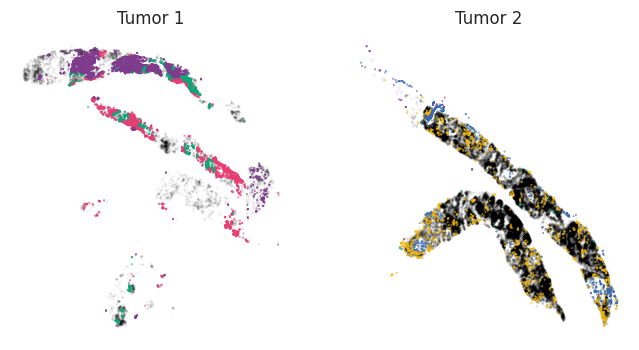

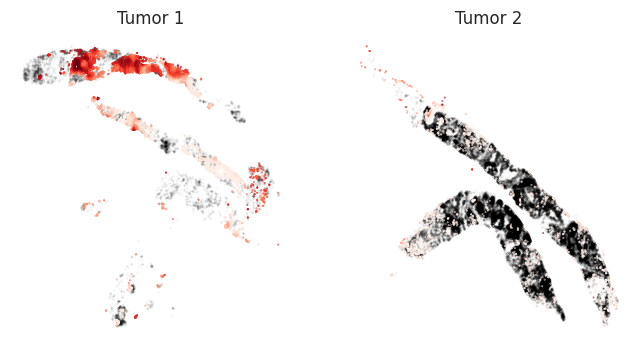

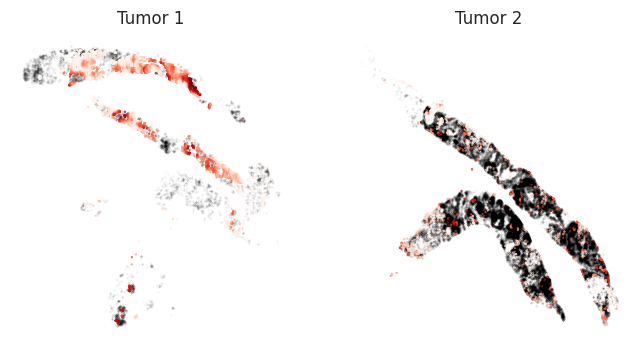

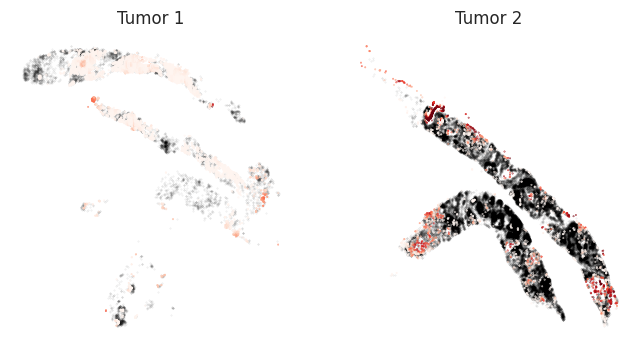

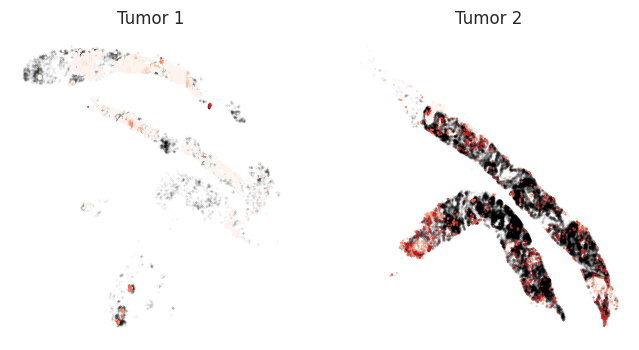

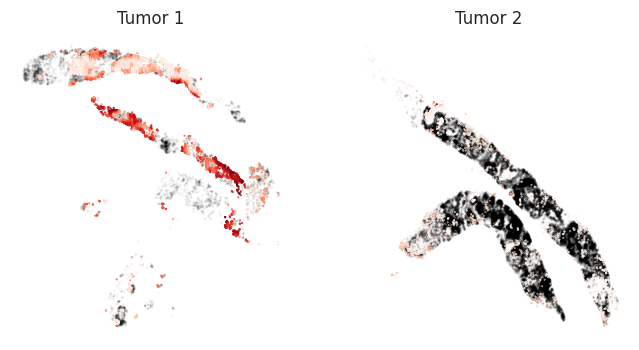

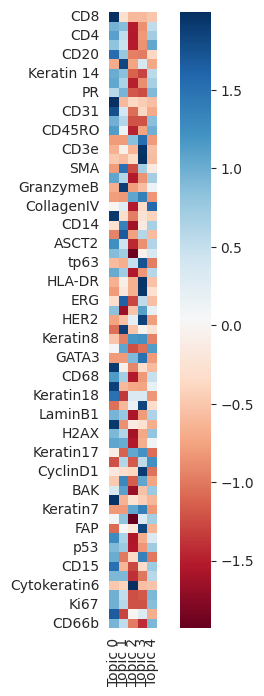

In [29]:
# visualizations
plot_samples_in_a_row(complete_lda.topic_weights, plot_one_tumor_all_topics, patient_dfs, tumor_set=[1, 2], size = 0.1)

for t in range(N_TOPICS):
  plot_samples_in_a_row(complete_lda.topic_weights.iloc[:, t], plot_one_tumor_topic, patient_dfs, tumor_set=[1, 2], size = 0.1)

# heatmap
plt.figure(figsize=(6, 8))
plot_topics_heatmap(complete_lda.components_, tumor_marker_features.columns)